In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
import sys

sys.path.append('/kaggle/input/haarpsi/')

In [3]:
import pickle
from haarPsi import *
from PIL import Image
import cv2
import pywt
from tqdm import tqdm
from numba import njit
from sklearn.metrics import *
from sklearn.cluster import spectral_clustering
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
def noisy1(image, mean=0, var=100):
    row,col = image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

In [5]:
def noisy2(image, std_percent=10.0):
    """
    Добавляет гауссовский шум на изображение.

    Args:
        image: ndarray. Исходное изображение.
        std_percent: float. Процент стандартного отклонения нормального распределения.

    Returns:
        ndarray. Зашумленное изображение.
    """
    # Нормализуем значения интенсивности пикселей к диапазону [0, 1].
    image = image.astype(np.float32) / 255.0

    # Генерируем матрицу шума с нулевым средним и стандартным отклонением,
    # определяемым заданным процентом от интенсивности каждого пикселя.
    noise = np.random.normal(loc=0, scale=image * std_percent / 100.0)

    # Добавляем шум к изображению.
    noisy_image = image + noise

    # Обрезаем значения интенсивности пикселей до диапазона [0, 1].
    noisy_image = np.clip(noisy_image, 0.0, 1.0)

    # Масштабируем значения интенсивности пикселей обратно в диапазон [0, 255] типа uint8.
    noisy_image = (noisy_image * 255.0).astype(np.uint8)

    return noisy_image

In [6]:
def aa(path):
    data = pd.DataFrame(columns=['image', 'label', 'number'])
    imlist = [(os.path.join(path, f), int(f[f.find('j') + 1 : f.find('_')]), int(f[f.find('_') + 2 : f.find('.')])) 
              for f in os.listdir(path) if f.endswith('.png')]
    for i, f in tqdm(enumerate(imlist)):
        im = Image.open(f[0])
        im = np.array(im).flatten()
        data.at[i, 'image'] = im.flatten()
        data.at[i, 'label'] = f[1]
        data.at[i, 'number'] = f[2]
                      
    return data

In [12]:
train = aa('/kaggle/input/columbia-university-image-library/coil-20/coil-20-proc/')

1440it [00:06, 206.96it/s]


In [13]:
train.sort_values('label', inplace=True)

In [14]:
train.reset_index(inplace=True, drop=True)

In [15]:
def bigger_class(x):
    if x in [1, 2, 13, 18]:
        return 1
    elif x in [3, 5, 6, 9, 10, 11, 19]:
        return 2
    elif x in [4, 12, 15, 16, 17, 20]:
        return 3
    else:
        return 4

In [16]:
def name_bigger_class(x):
    if x == 1:
        return 'Вытянуто горизонтально, несимметрично вдоль'
    elif x == 2:
        return 'Вытянуто горизонтально, симметрично вдоль'
    elif x == 3:
        return 'Симметрично'
    else:
        return 'Несимметрично'

In [17]:
train['class'] = train['label'].apply(bigger_class)

In [18]:
train['class_name'] = train['class'].apply(name_bigger_class)

In [19]:
train

,image,label,number,class,class_name
0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",1,49,1,"Вытянуто горизонтально, несимметрично вдоль"
1,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",1,56,1,"Вытянуто горизонтально, несимметрично вдоль"
2,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",1,32,1,"Вытянуто горизонтально, несимметрично вдоль"
3,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",1,23,1,"Вытянуто горизонтально, несимметрично вдоль"
4,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",1,16,1,"Вытянуто горизонтально, несимметрично вдоль"
...,...,...,...,...,...
1435,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,57,3,Симметрично
1436,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,9,3,Симметрично
1437,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,64,3,Симметрично
1438,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,4,3,Симметрично


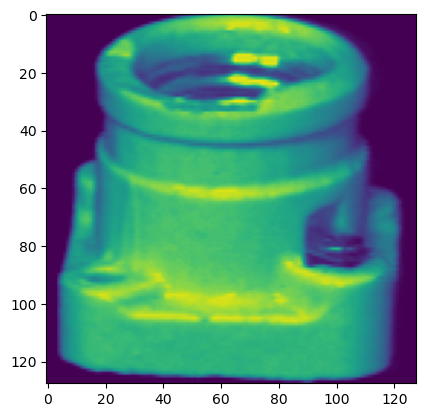

In [42]:
plt.imshow(np.resize(list(train['image'].loc[(train['label'] == 14) & (train['number'] == 0)]), (128, 128)))

### Считаем матрицу смежности c haarPsi

In [20]:
def sim_matrix_haar_psi(data, size):
    
    sim_matrix = np.zeros([size, size])
    
    for i in tqdm(range(size)):
        
        for j in range(i, size):

            res = haar_psi(data[i], data[j])[0]
            
            sim_matrix[i][j], sim_matrix[j][i] = res, res
            
    return sim_matrix

In [21]:
def resize_for_haar_psi(data):
    
    return [np.resize(img, (128, 128)) for img in data]

### Считаем матрицу смежности с CW-SSIM

#### Вейвлет Рикера

In [22]:
def get_signal(img1, img2):
    
    widths = np.arange(15, 18)

    cwtmatr1 = signal.cwt(img1, signal.ricker, widths)
    cwtmatr2 = signal.cwt(img2, signal.ricker, widths)
    
    return cwtmatr1, cwtmatr2

In [23]:
@njit(parallel=True)
def cw_ssim(cwtmatr1, cwtmatr2, k=0.01):
    
    c1c2_conj = np.multiply(cwtmatr1, np.conjugate(cwtmatr2))
    
    c1c2_sum = np.sum(c1c2_conj, axis=0)
    
    num_ssim = 2 * np.abs(c1c2_sum) + k
    
    c1_2 = np.square(np.abs(cwtmatr1))
    c2_2 = np.square(np.abs(cwtmatr2))
    
    den_ssim = np.sum(c1_2, axis=0) + np.sum(c2_2, axis=0) + k

    ssim_map = num_ssim / den_ssim

    # Average the per pixel results
    index = np.average(ssim_map)
    
    return index

In [24]:
def sim_matrix_cw(data, size):
    
    sim_m = np.zeros([size, size])
    
    for i in tqdm(range(size+1)):
        
        for j in range(i, size):
            
            cwtmatr1, cwtmatr2 = get_signal(data[i], data[j])
            
            res = cw_ssim(cwtmatr1, cwtmatr2)
            
            sim_m[i][j], sim_m[j][i] = res, res
            
            
    return sim_m

#### Метрика CW-SSIM с порождающей функцией Хаара (в качестве коэффициентов передаются коэффициенты дискретного вейвлет-преобразования Хаара)

В статье говорится, что порождающую вейвлет-функцию записывают как фильтр низких частот, поэтому здесь рассматриваются коэффициенты дискретного преобразования, полученные при фильтрации низких частот

In [25]:
def haar_signal(img1, img2):
    
    coef1, freq1 = pywt.dwt2(img1.reshape(128, 128), 'haar')
    coef2, freq2 = pywt.dwt2(img2.reshape(128, 128), 'haar')
    
    return coef1, coef2

In [26]:
def matrix_cw_haar(data, size):
    sim_m = np.zeros([size, size])
    
    for i in tqdm(range(size+1)):
        
        for j in range(i, size):
            
            cwtmatr1, cwtmatr2 = haar_signal(data[i], data[j])
            
            res = cw_ssim(cwtmatr1, cwtmatr2)
            
            sim_m[i][j], sim_m[j][i] = res, res
            
            
    return sim_m

In [24]:
#f = open('/kaggle/working/sim_matrix_cw_ssim_width_4_29_6.txt', 'r')

### Проверка классов на умение различать изображение с шумом

Сравнение метрик для исходного изображения и изображения с шумом для каждого поворота.

In [27]:
def check_noise_no_rot(data, label, noise_perc, name_label=None):
    y_cw_ricker = []
    y_cw_haar = []
    y_haar_psi = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    x = [num * 5 for num in range(72)]

    for i in range(len(sample)):
        image = sample.image[i]
        noisy_image = noisy2(np.resize(sample.image[i], (128, 128)), noise_perc)
        
        cw_ricker1, cw_ricker2 = get_signal(image.flatten(), noisy_image.flatten())
        y_cw_ricker.append(cw_ssim(cw_ricker1, cw_ricker2))

        cw_haar1, cw_haar2 = haar_signal(image, noisy_image)
        y_cw_haar.append(cw_ssim(cw_haar1, cw_haar2))

        y_haar_psi.append(haar_psi(np.resize(image, (128, 128)), 
                                    np.resize(noisy_image, (128, 128)))[0])
        
    #plt.imshow(np.resize(sample['image'][0], (128, 128)))
    #plt.show()
    #plt.imshow(np.resize(noisy2(np.resize(sample.image[0], (128, 128)), noise_perc), (128, 128)))
    #plt.show()
    
    #if name_label:
    #    plt.title(f'Класс №{label}: {name_label}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, y_cw_ricker, label='CW-SSIM with Ricker')
    #plt.plot(x, y_haar_psi, label='HaarPsi')
    #plt.plot(x, y_cw_haar, label='CW-SSIM with Haar')
    #plt.xlabel('Градус поворота')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return y_cw_ricker, y_cw_haar, y_haar_psi

In [21]:
cw_r = []
cw_h = []
h_p = []

for j in range(1, 21):
    r, h, p = check_noise_no_rot(train, j, 10)
    cw_r.append(r)
    cw_h.append(h)
    h_p.append(p)

/tmp/ipykernel_32/2235276361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)
/tmp/ipykernel_32/2235276361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


In [22]:
cw_r = np.array(cw_r).flatten()
cw_h = np.array(cw_h).flatten()
h_p = np.array(h_p).flatten()

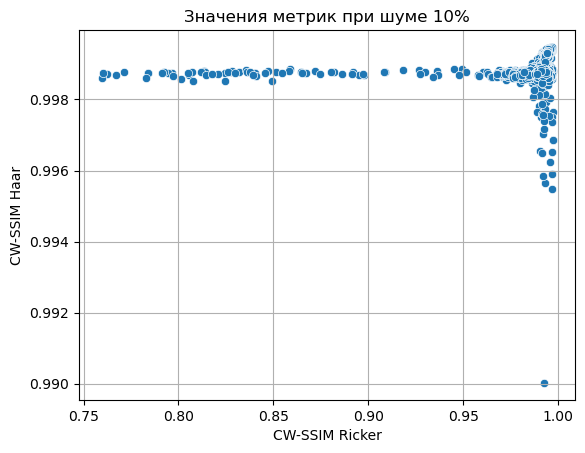

In [23]:
sns.scatterplot(x=cw_r, y=cw_h)
plt.title('Значения метрик при шуме 10%')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

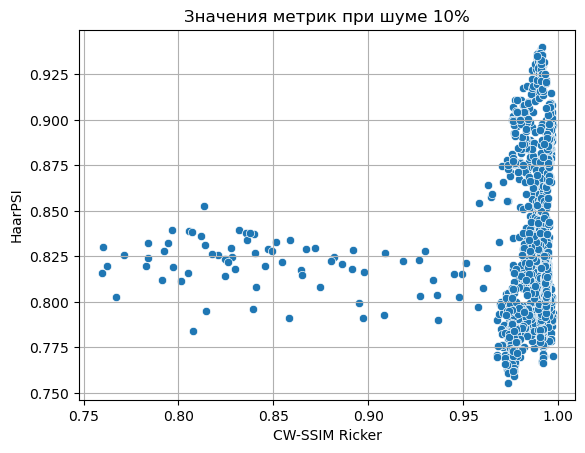

In [24]:
sns.scatterplot(x=cw_r, y=h_p)
plt.title('Значения метрик при шуме 10%')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

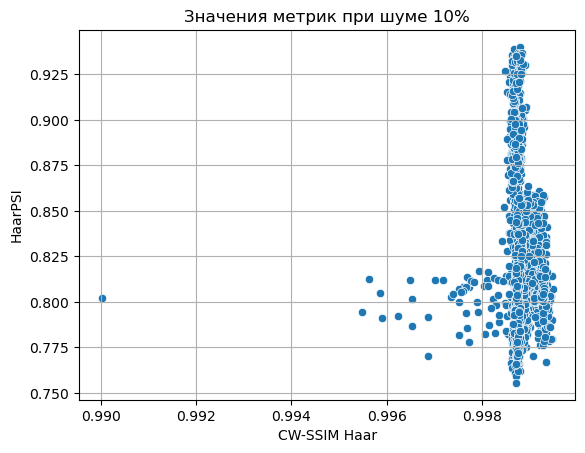

In [25]:
sns.scatterplot(x=cw_h, y=h_p)
plt.title('Значения метрик при шуме 10%')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

### Умение определять одинаковое изображение (без шума)

In [57]:
def check_image_no_noise(data, label, label_name=None):
    y_cw_ricker = []
    y_cw_haar = []
    y_haar_psi = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    x = [num * 5 for num in range(72)]
    
    image0 = sample.image[0]

    for i in range(len(sample)):
        image = sample.image[i]
        
        cw_ricker1, cw_ricker2 = get_signal(image0.flatten(), image.flatten())
        y_cw_ricker.append(cw_ssim(cw_ricker1, cw_ricker2))

        cw_haar1, cw_haar2 = haar_signal(image0, image)
        y_cw_haar.append(cw_ssim(cw_haar1, cw_haar2))

        y_haar_psi.append(haar_psi(np.resize(image0, (128, 128)), 
                                    np.resize(image, (128, 128)))[0])
    
    #plt.imshow(np.resize(image0, (128, 128)))
    #plt.show()
    
    #if label_name:
    #    plt.title(f'Класс №{label}: {label_name}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, y_cw_ricker, label='CW-SSIM with Ricker')
    #plt.plot(x, y_haar_psi, label='HaarPsi')
    #plt.plot(x, y_cw_haar, label='CW-SSIM with Haar')
    #plt.xlabel('Градус поворота')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return y_cw_ricker, y_cw_haar, y_haar_psi

In [58]:
cw_r_im = []
cw_h_im = []
h_p_im = []

for j in range(1, 21):
    r, h, p = check_image_no_noise(train, j)
    cw_r_im.append(r)
    cw_h_im.append(h)
    h_p_im.append(p)

/tmp/ipykernel_32/2003562695.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


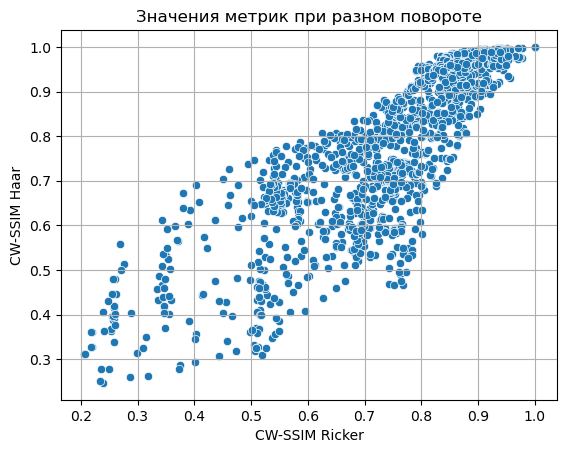

In [59]:
sns.scatterplot(x=np.array(cw_r_im).flatten(), y=np.array(cw_h_im).flatten())
plt.title('Значения метрик при разном повороте')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

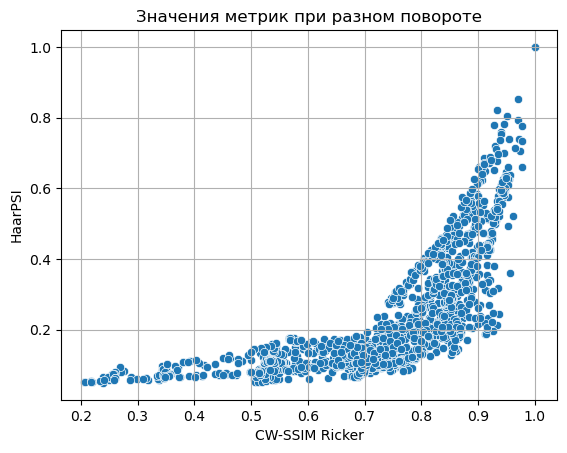

In [60]:
sns.scatterplot(x=np.array(cw_r_im).flatten(), y=np.array(h_p_im).flatten())
plt.title('Значения метрик при разном повороте')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

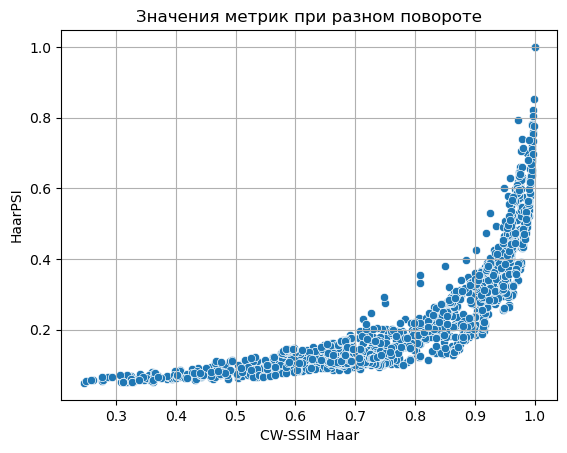

In [61]:
sns.scatterplot(x=np.array(cw_h_im).flatten(), y=np.array(h_p_im).flatten())
plt.title('Значения метрик при разном повороте')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

In [76]:
x2 = [5*i for i in range(72)]

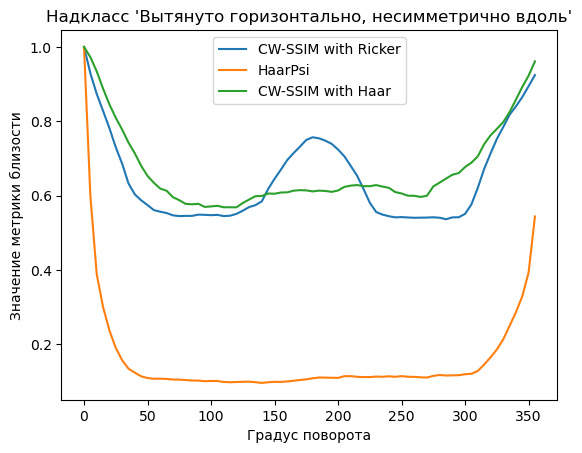

In [77]:
plt.title(f"Надкласс '{train['class_name'][0]}'")
plt.plot(x2, cw_r_1, label='CW-SSIM with Ricker')
plt.plot(x2, h_p_1, label='HaarPsi')
plt.plot(x2, cw_h_1, label='CW-SSIM with Haar')
plt.xlabel('Градус поворота')
plt.ylabel('Значение метрики близости')
plt.legend()
plt.show()

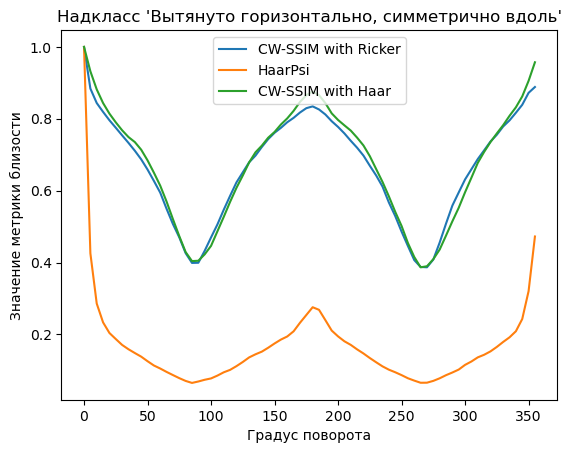

In [79]:
plt.title("Надкласс 'Вытянуто горизонтально, симметрично вдоль'")
plt.plot(x2, cw_r_2, label='CW-SSIM with Ricker')
plt.plot(x2, h_p_2, label='HaarPsi')
plt.plot(x2, cw_h_2, label='CW-SSIM with Haar')
plt.xlabel('Градус поворота')
plt.ylabel('Значение метрики близости')
plt.legend()
plt.show()

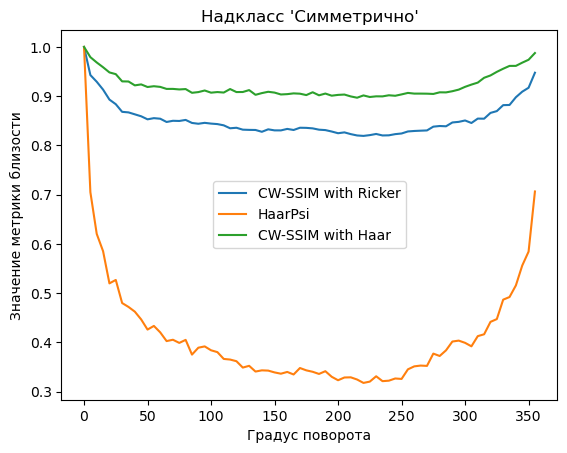

In [80]:
plt.title(f"Надкласс 'Симметрично'")
plt.plot(x2, cw_r_3, label='CW-SSIM with Ricker')
plt.plot(x2, h_p_3, label='HaarPsi')
plt.plot(x2, cw_h_3, label='CW-SSIM with Haar')
plt.xlabel('Градус поворота')
plt.ylabel('Значение метрики близости')
plt.legend()
plt.show()

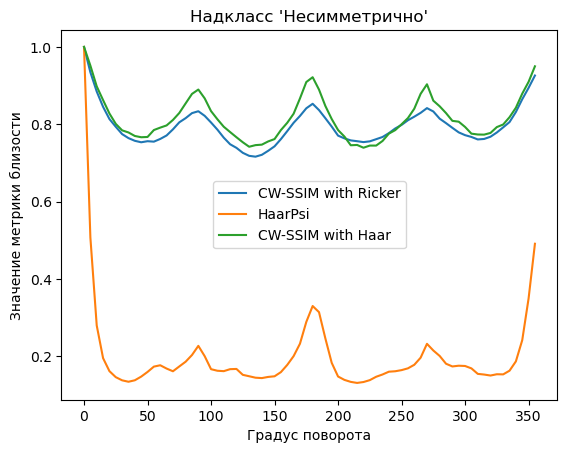

In [81]:
plt.title(f"Надкласс 'Несимметрично'")
plt.plot(x2, cw_r_4, label='CW-SSIM with Ricker')
plt.plot(x2, h_p_4, label='HaarPsi')
plt.plot(x2, cw_h_4, label='CW-SSIM with Haar')
plt.xlabel('Градус поворота')
plt.ylabel('Значение метрики близости')
plt.legend()
plt.show()

### Анализ реакции индекса близости на возмущения
Изменение дисперсии, которая равна заданному проценту от интенсивности пикселя

In [28]:
def test_var_mean1(data, label, num_images: list, percent_step, label_name=None):
    x = []
    cw_ricker_image = []
    haar_psi_image = []
    cw_haar_image = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    n = len(num_images)

    for i in range(0, 100, percent_step):
        
        x.append(i)
        
        cw_ricker_n = 0
        cw_haar_n = 0
        haar_n = 0
        
        for j in num_images:
            image = sample.image[j]
            noisy_image = noisy2(np.resize(image, (128, 128)), std_percent=i).flatten()

            cwtmatr1, cwtmatr2 = get_signal(image.flatten(), noisy_image)
            cw_ricker_n += cw_ssim(cwtmatr1, cwtmatr2)

            cw_haar1, cw_haar2 = haar_signal(image, noisy_image)
            cw_haar_n += cw_ssim(cw_haar1, cw_haar2)

            image_resize = resize_for_haar_psi([image, noisy_image])
            haar_n += haar_psi(image_resize[0], image_resize[1])[0]
            
        cw_ricker_image.append(cw_ricker_n / n)
        cw_haar_image.append(cw_haar_n / n)
        haar_psi_image.append(haar_n / n)
        
    #plt.imshow(np.resize(sample.image[0], (128, 128)))
    #plt.show()
        
    #if label_name:
    #    plt.title(f'Класс №{label}: {label_name}')
    #else:
    #    plt.title(f'Класс №{label}')
     
    #plt.plot(x, cw_ricker_image, label='CW-SSIM with Ricker')
    #plt.plot(x, haar_psi_image, label='HaarPsi')
    #plt.plot(x, cw_haar_image, label='CW-SSIM with Haar')
    #plt.xlabel('Процент от интенсивности')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return cw_ricker_image, cw_haar_image, haar_psi_image

In [34]:
mean_r1 = np.array([0.0 for i in range(20)])
mean_h1 = np.array([0.0 for i in range(20)])
mean_p1 = np.array([0.0 for i in range(20)])

for j in range(1, 21):
    r, h, p = test_var_mean1(train, j, np.array([0, 45, 90, 135, 180, 225, 270, 315]) / 5, 5)
    mean_r1 += np.array(r)
    mean_h1 += np.array(h)
    mean_p1 += np.array(p)

/tmp/ipykernel_32/1037858822.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


In [71]:
mean_r1 = mean_r1 / 20
mean_h1 = mean_h1 / 20
mean_p1 = mean_p1 / 20

x = [i for i in range(0, 100, 5)]

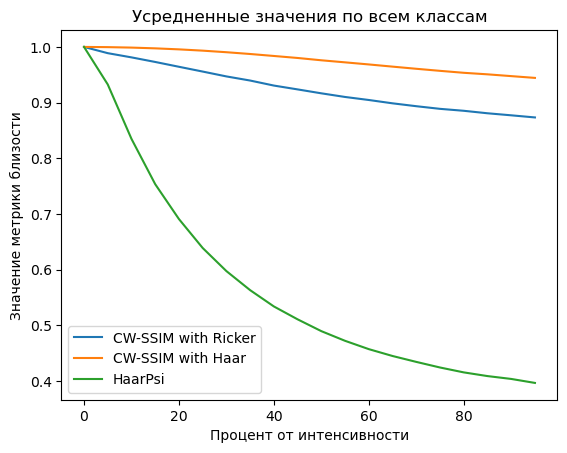

In [73]:
plt.plot(x, mean_r1, label='CW-SSIM with Ricker')
plt.plot(x, mean_h1, label='CW-SSIM with Haar')
plt.plot(x, mean_p1, label='HaarPsi')
plt.xlabel('Процент от интенсивности')
plt.ylabel('Значение метрики близости')
plt.title('Усредненные значения по всем классам')
plt.legend()
plt.show()

In [33]:
def test_var_mean2(data, label, percent_step, label_name=None):
    x = []
    cw_ricker_image = []
    haar_psi_image = []
    cw_haar_image = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    n = 50

    for i in range(0, 100, percent_step):
        
        x.append(i)
        
        cw_ricker_n = 0
        cw_haar_n = 0
        haar_n = 0
        
        image = sample.image[0]
        noisy_image = noisy2(np.resize(image, (128, 128)), std_percent=i).flatten()
        
        for j in range(n):

            cwtmatr1, cwtmatr2 = get_signal(image.flatten(), noisy_image)
            cw_ricker_n += cw_ssim(cwtmatr1, cwtmatr2)

            cw_haar1, cw_haar2 = haar_signal(image, noisy_image)
            cw_haar_n += cw_ssim(cw_haar1, cw_haar2)

            image_resize = resize_for_haar_psi([image, noisy_image])
            haar_n += haar_psi(image_resize[0], image_resize[1])[0]
            
        cw_ricker_image.append(cw_ricker_n / n)
        cw_haar_image.append(cw_haar_n / n)
        haar_psi_image.append(haar_n / n)
    
    return cw_ricker_image, cw_haar_image, haar_psi_image

In [34]:
mean_r2 = np.array([0.0 for i in range(20)])
mean_h2 = np.array([0.0 for i in range(20)])
mean_p2 = np.array([0.0 for i in range(20)])

for j in tqdm(range(1, 21)):
    r, h, p = test_var_mean2(train, j, 5)
    mean_r2 += np.array(r)
    mean_h2 += np.array(h)
    mean_p2 += np.array(p)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_32/2978387035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)
100%|██████████| 20/20 [05:30<00:00, 16.55s/it]


In [35]:
mean_r2 = mean_r2 / 20
mean_h2 = mean_h2 / 20
mean_p2 = mean_p2 / 20

In [37]:
x = [i for i in range(0, 100, 5)]

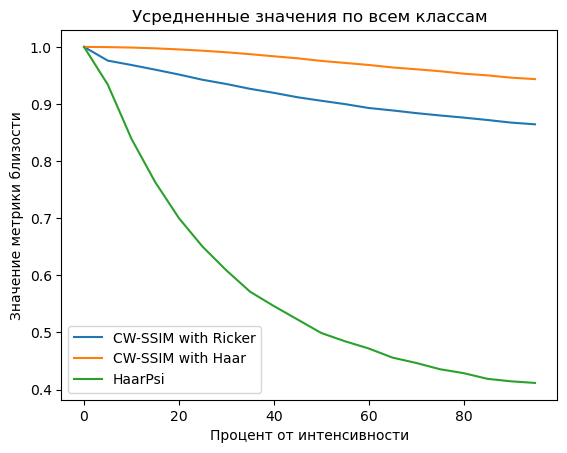

In [38]:
plt.plot(x, mean_r2, label='CW-SSIM with Ricker')
plt.plot(x, mean_h2, label='CW-SSIM with Haar')
plt.plot(x, mean_p2, label='HaarPsi')
plt.xlabel('Процент от интенсивности')
plt.ylabel('Значение метрики близости')
plt.title('Усредненные значения по всем классам')
plt.legend()
plt.show()

In [41]:
def test_var_mean3(data, labels, percent_step, label_name=None):
    x = []
    cw_ricker_image = []
    haar_psi_image = []
    cw_haar_image = []
    
    sample1 = data.loc[data.label == labels[0]]
    sample1.sort_values('number', inplace=True)
    sample1.reset_index(drop=True, inplace=True)
    
    sample2 = data.loc[data.label == labels[1]]
    sample2.sort_values('number', inplace=True)
    sample2.reset_index(drop=True, inplace=True)
    
    n = 100

    for i in tqdm(range(0, 100, percent_step)):
        
        x.append(i)
        
        cw_ricker_n = 0
        cw_haar_n = 0
        haar_n = 0
        
        noisy_image1 = noisy2(np.resize(sample1.image[0], (128, 128)), std_percent=i).flatten()
        noisy_image2 = noisy2(np.resize(sample2.image[0], (128, 128)), std_percent=i).flatten()
        
        for j in range(100):

            cwtmatr1, cwtmatr2 = get_signal(noisy_image1, noisy_image2)
            cw_ricker_n += cw_ssim(cwtmatr1, cwtmatr2)

            cw_haar1, cw_haar2 = haar_signal(noisy_image1, noisy_image2)
            cw_haar_n += cw_ssim(cw_haar1, cw_haar2)

            image_resize = resize_for_haar_psi([noisy_image1, noisy_image2])
            haar_n += haar_psi(image_resize[0], image_resize[1])[0]
            
        cw_ricker_image.append(cw_ricker_n / n)
        cw_haar_image.append(cw_haar_n / n)
        haar_psi_image.append(haar_n / n)
    
    return cw_ricker_image, cw_haar_image, haar_psi_image

/tmp/ipykernel_32/4015879503.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample1.sort_values('number', inplace=True)
/tmp/ipykernel_32/4015879503.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample2.sort_values('number', inplace=True)
100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


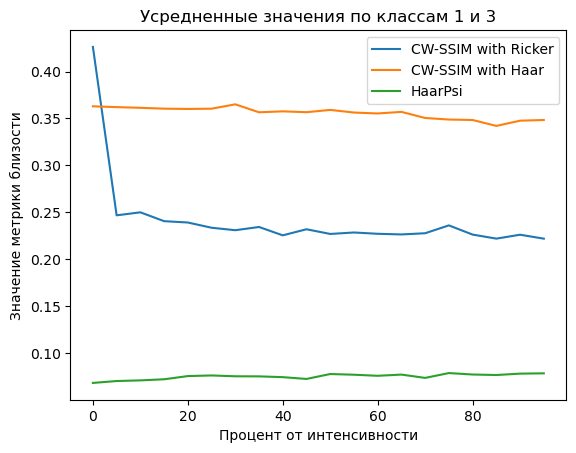

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


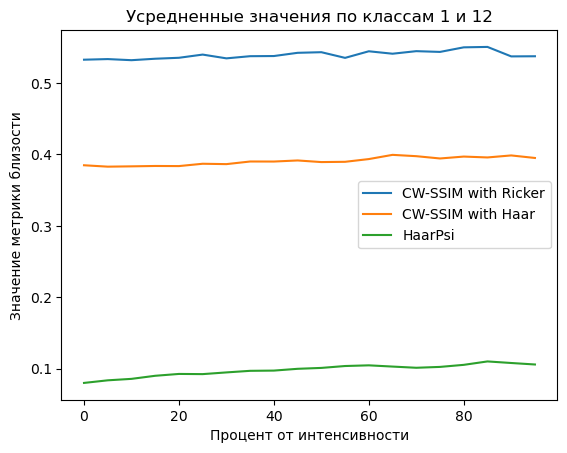

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


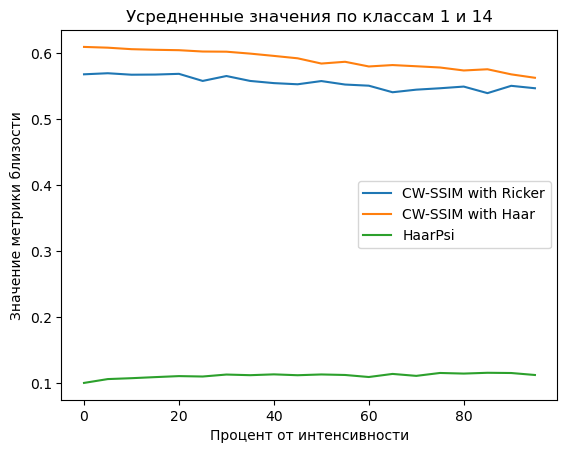

In [42]:
mean_r3 = np.array([0.0 for i in range(20)])
mean_h3 = np.array([0.0 for i in range(20)])
mean_p3 = np.array([0.0 for i in range(20)])

for j in [3, 12, 14]:
    r, h, p = test_var_mean3(train, [1, j], 5)
    plt.plot(x, r, label='CW-SSIM with Ricker')
    plt.plot(x, h, label='CW-SSIM with Haar')
    plt.plot(x, p, label='HaarPsi')
    plt.xlabel('Процент от интенсивности')
    plt.ylabel('Значение метрики близости')
    plt.title(f'Усредненные значения по классам 1 и {j}')
    plt.legend()
    plt.show()

### Снижение размерности графа для 4х классов

In [25]:
sample_1_4 = train.loc[train['label'].isin([1, 3, 12, 14])]

In [26]:
sample_1_4.reset_index(inplace=True)

In [29]:
def smaller_graph(matrix, thresh):
    
    sim_m = np.zeros(matrix.shape)
    
    #G = nx.Graph(matrix, nodetype=int)
    
    #comp_numb = nx.number_connected_components(G)
    
    for i in range(matrix.shape[0]):
        
        for j in range(i, matrix.shape[1]):
            
            if matrix[i][j] > thresh:
            
                sim_m[i][j], sim_m[j][i] = matrix[i][j], matrix[j][i]
                
                #if nx.number_connected_components(nx.Graph(sim, nodetype=int)) != comp_numb:
                    
                #    sim_m[i][j], sim_m[i][j] = matrix[i][j], matrix[j][i]
            
    return sim_m

In [35]:
cw_matr_1_4 = sim_matrix_cw(sample_1_4.image, len(sample_1_4.image))

100%|██████████| 289/289 [03:50<00:00,  1.25it/s]


In [36]:
resize_sample_1_4 = resize_for_haar_psi(sample_1_4.image)

In [37]:
haar_matr_1_4 = sim_matrix_haar_psi(resize_sample_1_4, len(resize_sample_1_4))

100%|██████████| 288/288 [05:37<00:00,  1.17s/it]


In [38]:
cw_haar_1_4 = matrix_cw_haar(sample_1_4.image, len(sample_1_4.image))

100%|██████████| 289/289 [00:35<00:00,  8.13it/s]


In [39]:
small_cw_matr_1_4 = smaller_graph(cw_matr_1_4, 0.1)

In [40]:
small_haar_matr_1_4 = smaller_graph(haar_matr_1_4, 0.1)

In [41]:
small_cw_haar_1_4 = smaller_graph(cw_haar_1_4, 0.1)

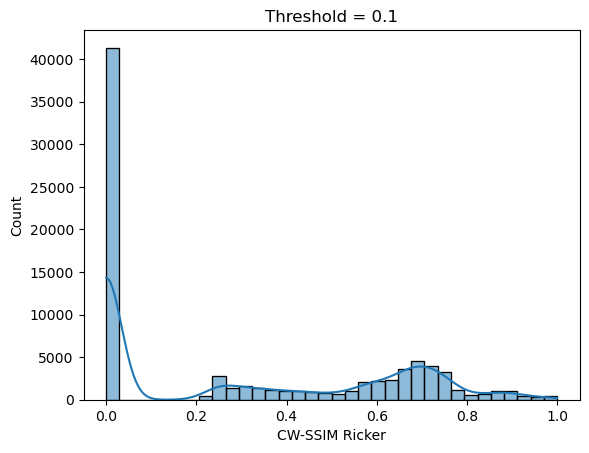

In [42]:
sns.histplot(np.array(np.triu(small_cw_matr_1_4).reshape(-1).tolist()), kde=True)
plt.xlabel('CW-SSIM Ricker')
plt.title('Threshold = 0.1')
plt.show()

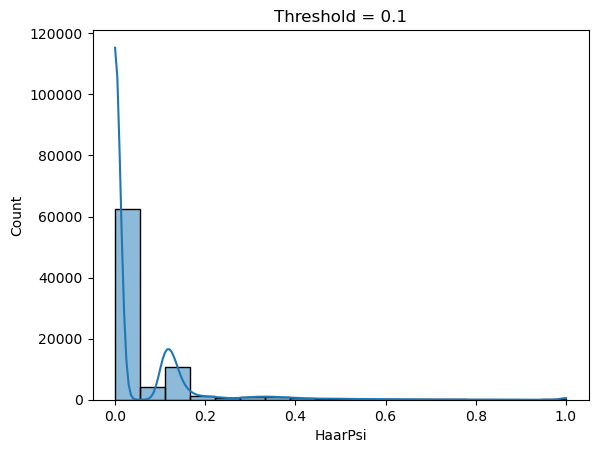

In [43]:
sns.histplot(np.array(np.triu(small_haar_matr_1_4).reshape(-1).tolist()), kde=True)
plt.xlabel('HaarPsi')
plt.title('Threshold = 0.1')
plt.show()

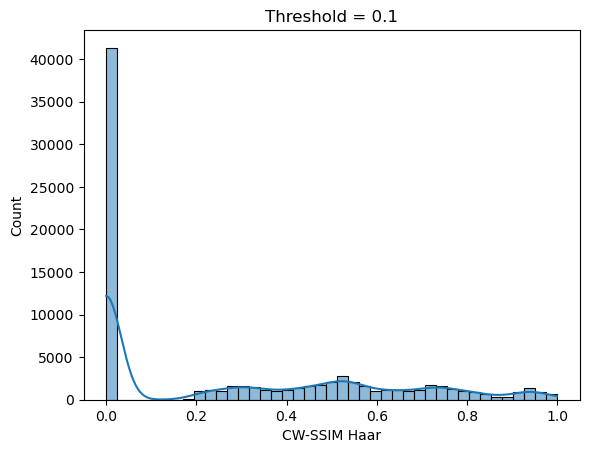

In [44]:
sns.histplot(np.array(np.triu(small_cw_haar_1_4).reshape(-1).tolist()), kde=True)
plt.xlabel('CW-SSIM Haar')
plt.title('Threshold = 0.1')
plt.show()

### Кластеризация данных с 4мя классами без шума

In [45]:
thresh = [i * 0.005 for i in range(100)]

In [52]:
spectral_cw_res_1_4 = []
spectral_haar_res_1_4 = []
spectral_cw_haar_1_4 = []

for t in tqdm(thresh):
    small_cw_m = smaller_graph(cw_matr_1_4, t)
    
    cw_classes = spectral_clustering(small_cw_m, n_clusters=4)
    spectral_cw_res_1_4.append(adjusted_rand_score(sample_1_4.label, cw_classes))
    
    small_haar_m = smaller_graph(haar_matr_1_4, t)
    
    haar_classes = spectral_clustering(small_haar_m, n_clusters=4)
    spectral_haar_res_1_4.append(adjusted_rand_score(sample_1_4.label, haar_classes))
    
    small_cw_haar = smaller_graph(cw_haar_1_4, t)
    
    cw_haar_classes = spectral_clustering(small_cw_haar, n_clusters=4)
    spectral_cw_haar_1_4.append(adjusted_rand_score(sample_1_4.label, cw_haar_classes))

 29%|██▉       | 29/100 [00:18<00:39,  1.80it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 30%|███       | 30/100 [00:18<00:38,  1.80it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 31%|███       | 31/100 [00:19<00:38,  1.80it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 32%|███▏      | 32/100 [00:19<00:38,  1.78it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 33%|███▎      | 33/100 [00:20<00:37,  1.78it/s]

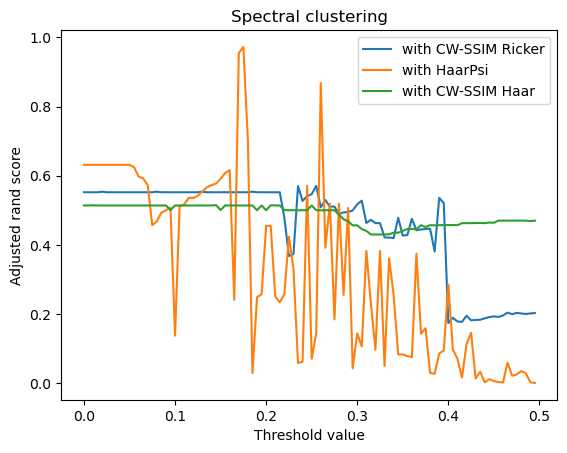

In [53]:
plt.plot(thresh, spectral_cw_res_1_4, label='with CW-SSIM Ricker')
plt.plot(thresh, spectral_haar_res_1_4, label='with HaarPsi')
plt.plot(thresh, spectral_cw_haar_1_4, label='with CW-SSIM Haar')
plt.xlabel('Threshold value')
plt.ylabel('Adjusted rand score')
plt.title('Spectral clustering')
plt.legend()
plt.show()

In [54]:
from community import community_louvain

In [55]:
louvain_cw_res_1_4 = []
louvain_haar_res_1_4 = []
louvain_cw_haar_1_4 = []

for t in tqdm(thresh):
    small_cw_m = smaller_graph(cw_matr_1_4, t)
    
    G_cw = nx.Graph(small_cw_m)
    
    cw_classes_louv = community_louvain.best_partition(G_cw)
    louvain_cw_res_1_4.append(adjusted_rand_score(sample_1_4.label, list(cw_classes_louv.values())))
    
    small_haar_m = smaller_graph(haar_matr_1_4, t)
    
    G_haar = nx.Graph(small_haar_m)
    
    haar_classes_louv = community_louvain.best_partition(G_haar)
    louvain_haar_res_1_4.append(adjusted_rand_score(sample_1_4.label, list(haar_classes_louv.values())))
    
    small_cw_haar = smaller_graph(cw_haar_1_4, t)
    
    G_cw_haar = nx.Graph(small_cw_haar)
    
    cw_haar_classes_lv = community_louvain.best_partition(G_cw_haar)
    louvain_cw_haar_1_4.append(adjusted_rand_score(sample_1_4.label, list(cw_haar_classes_lv.values())))

100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


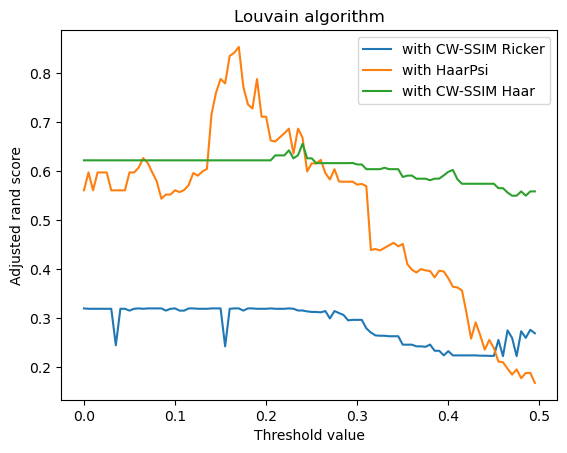

In [56]:
plt.plot(thresh, louvain_cw_res_1_4, label='with CW-SSIM Ricker')
plt.plot(thresh, louvain_haar_res_1_4, label='with HaarPsi')
plt.plot(thresh, louvain_cw_haar_1_4, label='with CW-SSIM Haar')
plt.xlabel('Threshold value')
plt.ylabel('Adjusted rand score')
plt.title('Louvain algorithm')
plt.legend()
plt.show()

In [57]:
 from sklearn.cluster import DBSCAN

In [58]:
dbscan_cw_res_1_4 = []
dbscan_haar_res_1_4 = []
dbscan_cw_haar_1_4 = []

for t in tqdm(thresh):
    small_cw_m = smaller_graph(cw_matr_1_4, t)
    
    cw_classes_dbscan = DBSCAN(eps=1.2, min_samples=2).fit(small_cw_m)
    dbscan_cw_res_1_4.append(adjusted_rand_score(sample_1_4.label, cw_classes_dbscan.labels_))
    
    small_haar_m = smaller_graph(haar_matr_1_4, t)
    
    haar_classes_dbscan = DBSCAN(eps=1.2, min_samples=2).fit(small_haar_m)
    dbscan_haar_res_1_4.append(adjusted_rand_score(sample_1_4.label, haar_classes_dbscan.labels_)) 
    
    small_cw_haar = smaller_graph(cw_haar_1_4, t)
    
    cw_haar_classes_dbscan = DBSCAN(eps=1.2, min_samples=2).fit(small_cw_haar)
    dbscan_cw_haar_1_4.append(adjusted_rand_score(sample_1_4.label, cw_haar_classes_dbscan.labels_))

100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


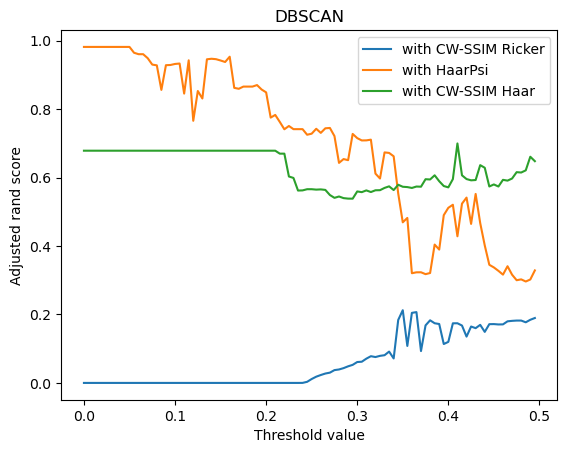

In [59]:
plt.plot(thresh, dbscan_cw_res_1_4, label='with CW-SSIM Ricker')
plt.plot(thresh, dbscan_haar_res_1_4, label='with HaarPsi')
plt.plot(thresh, dbscan_cw_haar_1_4, label='with CW-SSIM Haar')
plt.xlabel('Threshold value')
plt.ylabel('Adjusted rand score')
plt.title("DBSCAN")
plt.legend()
plt.show()